In [1]:
from keras.models import Model
from keras.layers import LSTM, Input
from keras.utils.np_utils import to_categorical
from PointerLSTM import PointerLSTM as Pointerv0
import numpy as np

from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
%reload_ext autoreload
%autoreload 2

In [8]:
import keras.backend as K
from keras.activations import tanh, softmax
from keras.layers import RNN, LSTM, LSTMCell, Dense, Layer, Masking
import keras

In [9]:
def order(X, by_idx=False):
    # Are these the same?!
    # Ip => Index I occupying pth position
    y = X.argsort()

    if not by_idx:
        return y

    # Pi => Position P for ith index
    return y.argsort()

In [10]:
def gen_seq(**kwargs):
    X = np.random.randint(**kwargs)

    def _order(order_by_idx=False):
        y = order(X, order_by_idx)
        return X, y

    return _order

In [19]:
def gen_data(N, seq_len, order_by_idx=False, low=0, high=100):
    seq_gen = gen_seq(low=low, high=high, size=(N, seq_len))

    X, y = seq_gen(order_by_idx=False)
    return X, y

In [41]:
class Attention(Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.V = Dense(1, use_bias=False)

    def call(self, X_enc, X_dec, mask=None):
        print('mask:', mask)
        h_enc = self.W1(X_enc)
        h_dec = self.W1(X_dec)
        h_dec = K.repeat(h_dec, h_enc.shape[1])

        u = tanh(h_enc + h_dec)
        u = self.V(u)
        u = K.squeeze(u, axis=2)

        if mask is not None:
            mask_values = K.cast(mask[0], u.dtype)
            u += mask_values * -np.infty
                
        a = softmax(u, axis=1)
        return a

In [158]:
class PointerLSTMCell(LSTMCell):
    def __init__(self, units, **kwargs):
        super(PointerLSTMCell, self).__init__(units, **kwargs)
        self.attention = Attention(units)

    def call(self, inputs, states, constants=None, mask=None, training=None):
        print('mask:', mask)
        
        X_enc = constants[0]
        out, [h, c] = super(PointerLSTMCell, self).call(inputs, states, training=training)        
        probs = self.attention(X_enc, h)

        # Pointing        
        idx = K.argmax(probs)
        idx = K.expand_dims(idx)
        r = K.arange(idx.shape[0], dtype=idx.dtype)
        r = K.expand_dims(r)
        
        indices = K.concatenate((r, idx))
        h = tf.gather_nd(X_enc, indices)
        return probs, [h, c]


In [159]:
class PointerLSTM(Layer):
    def __init__(self, units, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, **kwargs):
        cell = PointerLSTMCell(units, **kwargs)
        self.rnn = RNN(cell, return_sequences=return_sequences, return_state=return_state, go_backwards=go_backwards, stateful=stateful, unroll=unroll, time_major=time_major, **kwargs)
        super(PointerLSTM, self).__init__(**kwargs)
    
    def call(self, inputs, initial_state=None, constants=None, **kwargs):
        print(kwargs)
        return self.rnn(inputs, initial_state=initial_state, constants=constants, **kwargs)


In [160]:
N = 10000
seq_len = 5
X, y = gen_data(N, seq_len, low=0, high=1000)

In [161]:
split = int(0.8 * N)

_X = X / np.expand_dims(X.max(axis=1), axis=1)
_X = np.expand_dims(_X, axis=2)

X_train = _X[:split]
y_train = y[:split]

X_test = _X[split:]
y_test = y[split:]

X_train.shape, y_train.shape

((8000, 5, 1), (8000, 5))

In [162]:
y_train_cat = to_categorical(y_train)
y_train_cat.shape

(8000, 5, 5)

In [163]:
X_train[:2, -2:] = -1
# X_train

In [164]:
seq_shape = X_train.shape[1:]
hidden_units = 64
batch_size = 32

inputs = Input(shape=seq_shape, name='main_input', batch_size=batch_size)
inputs = Masking(mask_value=-1) (inputs)
enc, state_h, state_c = LSTM(hidden_units, name='encoder', 
                            return_sequences=True, return_state=True) (inputs)
dec, _, _ = PointerLSTM(hidden_units, name='decoder', return_sequences=True, return_state=True) \
                    (enc, initial_state=[state_h, state_c], constants=enc)

# cell = PointerLSTMCell(hidden_units)
# dec, _, _ = RNN(cell, name='decoder', return_sequences=True, return_state=True) \
#                     (enc, initial_state=[state_h, state_c], constants=enc)


model = Model(inputs, dec)
model.summary()

{'mask': <tf.Tensor 'Placeholder_4:0' shape=(32, 5) dtype=bool>, 'training': None}
mask: None
mask: None
mask: None
mask: None
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(32, 5, 1)]         0           []                               
                                                                                                  
 encoder (LSTM)                 [(32, 5, 64),        16896       ['input_18[0][0]']               
                                 (32, 64),                                                        
                                 (32, 64)]                                                        
                                                                                                  
 decoder (PointerLSTM)          [(32, 5, 5),         37184     

In [165]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [166]:
nb_epochs = 2
h = model.fit(X_train, y_train_cat,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/2
{'training': True}
mask: None
mask: None
mask: None
mask: None
{'training': True}
mask: None
mask: None
mask: None
mask: None
250/250 [==============================] - 4s 5ms/step - loss: 1.2111 - accuracy: 0.4394
Epoch 2/2
250/250 [==============================] - 1s 5ms/step - loss: 0.4557 - accuracy: 0.8336


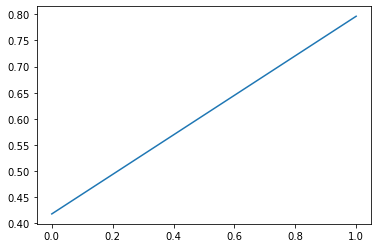

In [130]:
plt.plot(h.history['accuracy'])

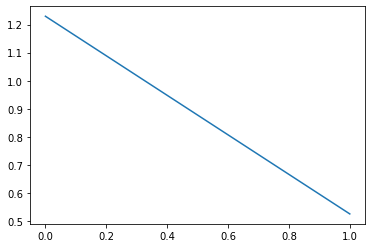

In [131]:
plt.plot(h.history['loss'])

In [132]:
model.evaluate(X_test, to_categorical(y_test))

mask: None
mask: None
mask: None
mask: None
42/63 [===================>..........] - ETA: 0s - loss: 0.3703 - accuracy: 0.8677

CancelledError:  Loop execution was cancelled.
	 [[{{node model_14/decoder/while/LoopCond/_25}}]] [Op:__inference_test_function_107973]

In [133]:
y_pred = model.predict(X_test)
y_pred.argmax(axis=2)

mask: None
mask: None
mask: None
mask: None


CancelledError:  Loop execution was cancelled.
	 [[{{node model_14/decoder/while/LoopCond/_25}}]] [Op:__inference_predict_function_108923]

In [617]:
y_pred.argmax(axis=1)

array([[1, 4, 2, 0, 3],
       [1, 3, 4, 2, 0]])

In [618]:
y_pred

array([[[1.1552392e-20, 4.2896540e-25, 6.6231989e-24, 1.0000000e+00,
         1.8110539e-25],
        [1.0000000e+00, 6.2883201e-18, 3.7587857e-09, 1.8930853e-12,
         5.9332793e-18],
        [1.7274615e-09, 2.2749619e-13, 1.0000000e+00, 1.3627531e-12,
         6.8411477e-13],
        [1.6683276e-15, 4.6446465e-11, 2.1712000e-15, 1.6277672e-15,
         1.0000000e+00],
        [1.6031254e-21, 1.0000000e+00, 1.8016862e-21, 1.4586381e-21,
         6.7732348e-12]],

       [[3.2948769e-20, 9.1745835e-25, 1.0528925e-21, 1.0848638e-24,
         1.0000000e+00],
        [1.0000000e+00, 8.0538791e-17, 6.4855116e-17, 2.5595385e-15,
         1.0554941e-14],
        [6.6852956e-14, 2.1494835e-09, 2.5511805e-18, 1.0000000e+00,
         1.5633183e-17],
        [1.2325668e-15, 1.0000000e+00, 1.3090109e-15, 1.3575859e-11,
         1.0564523e-15],
        [5.4883020e-20, 4.2644102e-19, 1.0000000e+00, 7.9029740e-20,
         5.4938532e-20]]], dtype=float32)

In [582]:
y_test[:2]

array([[3, 2, 4, 0, 1],
       [1, 3, 0, 4, 2]])

In [584]:
X_test[:2]

array([[[0.97341211],
        [1.        ],
        [0.79615953],
        [0.42245199],
        [0.79615953]],

       [[0.49612403],
        [0.45847176],
        [1.        ],
        [0.46290144],
        [0.9944629 ]]])

In [585]:
y_pos = order(X_test[..., 0])
y_idx = order(X_test[..., 0], True)

In [586]:
np.equal(y_pos, y_test).sum()

10000

In [587]:
y_pred = model.predict(X_test)

In [588]:
np.equal(y_idx, y_pred.argmax(axis=1)).sum() / np.product(y_test.shape) 

0.9685

In [589]:
np.equal(y_pos, y_pred.argmax(axis=2)).sum() / np.product(y_test.shape)

0.9619

In [592]:
y_pred = model.predict([[[1.0], [1.0], [0.5], [0.2], [0.2]]])
y_pred.argmax(axis=2), y_pred.argmax(axis=1)

(array([[3, 4, 2, 0, 1]]), array([[3, 4, 2, 0, 1]]))

In [593]:
y_pred = model.predict([[[1.0], [1.0], [1.0], [1.0], [1.0]]])
y_pred.argmax(axis=2), y_pred.argmax(axis=1)

(array([[4, 4, 0, 1, 3]]), array([[1, 3, 2, 4, 1]]))

In [18]:
enc, state = K.zeros((32, 5, 64)), [K.zeros((32, 64)), K.zeros((32, 64))]
p = PointerLSTM(64, return_sequences=True, return_state=True, name='decoder')
_ = p.call(enc, initial_state=state, constants=[enc])

2021-12-19 04:13:42.541700: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# seq_shape = X_train.shape[1:]
# hidden_units = 64

# main_input = Input(shape=seq_shape, name='main_input')
# encoder, state_h, state_c = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True) (main_input)
# decoder = Pointerv0(hidden_units, name='decoder') (encoder, states=[state_h, state_c])

# model2 = Model(main_input, decoder)
# model2.summary()

In [ ]:
a = np.array([[[1, 2, 3], [4, 5, 6]]]) 
b = np.array([[[4, 5, 6]]])
a.shape, b.shape

c = a + b
c.shape

In [ ]:
units = 2
att = Attention(units)
X_enc = K.constant( np.random.random((10, 5, units)) )
X_dec = K.constant( np.random.random((10, units)) )
scores = att(X_enc, X_dec)
scores.shape